推荐系统的相似度计算方式有很多，通常根据所处理的数据集来进行选择：
* 实现用户协同过滤、物品协同过滤、矩阵分解算法
* 将rating.dat按照8:2划分为训练集与测试集
* 采用MSE作为评测指标
***
数据集特点：
rating.dat

-用户编号：1-6040

-物品（电影）编号：1-3952

-评分范围：1-5（5级制），注意没有0分，0分可以用于判定用户没有给该电影评过分


In [0]:
import numpy as np
import math
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

### 数据预处理

In [0]:
def load_ml_1m(path,path_name='ratings.dat'):
  data_col = ['user_id', 'item_id', 'rating', 'timestamp']
  data = pd.read_table(path+'ratings.dat',sep='::',header=None, names=data_col,engine='python')
  data.drop('timestamp',axis=1,inplace=True)    # 去除最后一列
  return data

In [0]:
path='/content/drive/My Drive/recommend_system/data/'
data = load_ml_1m(path)
print(data.shape)

(1000209, 3)


In [0]:
data.head(n=20)

In [0]:
# 划分ml-1m数据集
def split_dataframe(df):
  user_ids=df['user_id'].unique()
  user_n=len(user_ids)
  train_df = pd.DataFrame(columns=('user_id','item_id','rating'))
  test_df = pd.DataFrame(columns=('user_id','item_id','rating'))
  # 按照8：2划分训练集、测试集，这里随机拿出每个用户的80%评分记录组合成训练集，剩余20%是测试集
  for tmp_id in tqdm(range(1,user_n+1)):
    tmp_df = df[data.user_id==tmp_id]
    tmp_train = tmp_df.sample(frac=0.8)
    tmp_test = tmp_df.drop(tmp_train.index)
    train_df = train_df.append(tmp_train,ignore_index=True)
    test_df = test_df.append(tmp_test,ignore_index=True)
  return train_df,test_df

In [0]:
train_df,test_df = split_dataframe(data) 

100%|██████████| 6040/6040 [02:05<00:00, 48.14it/s]


In [0]:
train_df.to_csv(path+'train_df.csv',index=False) # 不要写入索引序列
test_df.to_csv(path+'test_df.csv',index=False) # 不要写入索引序列

### 数据加载

In [0]:
path = '/content/drive/My Drive/recommend_system/data/'
train_df = pd.read_csv(path+'train_df.csv')
test_df = pd.read_csv(path+'test_df.csv')

In [0]:
print(train_df.head())
print(train_df.shape)

   user_id  item_id  rating
0        1      745       3
1        1     1193       5
2        1      150       5
3        1      608       4
4        1     3186       4
(800193, 3)


In [0]:
print(test_df.head())
print(test_df.shape)

   user_id  item_id  rating
0        1      914       3
1        1     2355       5
2        1     2804       5
3        1      919       4
4        1      527       5
(200016, 3)


In [0]:
# build user-item dic，  user_id:item_list
# build item-user dic,  item_id:user_list
def build_dictionary(train_df):
  user_item_dic={}
  item_user_dic={}
  for row_record in tqdm(train_df.itertuples()):
    user_id = getattr(row_record,'user_id')
    item_id = getattr(row_record,'item_id')
    rating = getattr(row_record,'rating')
    # build user-->item dictionary
    if user_id in user_item_dic:
      user_item_dic.get(user_id).append(item_id)
    else:
      user_item_dic[user_id] = [item_id]
    # build item-user dictionary
    if item_id in item_user_dic:
      item_user_dic.get(item_id).append(user_id)
    else:
      item_user_dic[item_id] = [user_id]

  return user_item_dic,item_user_dic 

In [5]:
user_item_dic,item_user_dic = build_dictionary(train_df)
print(len(user_item_dic.keys()))

800193it [00:01, 600099.40it/s]

6040


In [0]:
# 建立用户-评分矩阵(dataframe)
def user_item_score(df):
    row_num = df.shape[0]
    user_names=df['user_id'].unique()
    item_names=df['item_id'].unique()
    user_n=len(user_names)
    item_n=len(item_names)
    user_item_matrix = pd.DataFrame(np.zeros((user_n,item_n)),index=user_names,columns=item_names)
    iterable = iter(df.itertuples())
    for num in tqdm(range(1,row_num+1)):
      i = next(iterable)
      user_item_matrix.loc[getattr(i,'user_id'),getattr(i,'item_id')]=getattr(i,'rating')
    return user_item_matrix
user_item_matrix = user_item_score(train_df)  # need 2:50s

100%|██████████| 800193/800193 [02:29<00:00, 5340.23it/s]


In [0]:
user_item_matrix.shape

(6040, 3683)

In [0]:
import pickle
user_item_matrix_np = user_item_matrix.values
def store_pkl(souce_object,path_file): 
  # Its important to use binary mode 
  dbfile = open(path_file, 'ab') 
  # source, destination 
  pickle.dump(souce_object,dbfile)					 
  dbfile.close() 
 
def load_pkl(path_file): 
  # for reading also binary mode is important 
  dbfile = open(path_file, 'rb')	 
  db = pickle.load(dbfile)  
  dbfile.close()
  return db 
 


In [0]:
# user_item_matrix.to_csv(path+'train_user_item_matrix.csv',index=False) # 保存训练集的用户评分矩阵

In [0]:
user_item_matrix = pd.read_csv(path + 'user_item_matrix.csv')
user_item_matrix_np = user_item_matrix.values

In [0]:
item_id_list=user_item_matrix.columns
item_map_dic={}  # 用于用户评分矩阵是无序的，建立item_id-->index的映射
for i,col_id in enumerate(item_id_list):
  item_map_dic[int(col_id)] = i 

In [21]:
print(item_map_dic[1961])    #  
print(len(item_user_dic[1])) 
print(item_user_dic[1])

5
1683
[1, 9, 10, 18, 19, 21, 23, 26, 34, 36, 38, 48, 49, 51, 56, 60, 65, 68, 73, 75, 78, 80, 90, 92, 96, 99, 109, 112, 117, 118, 119, 121, 123, 131, 132, 134, 139, 142, 146, 148, 150, 151, 152, 156, 157, 162, 163, 168, 169, 173, 175, 182, 184, 186, 190, 194, 195, 202, 213, 214, 215, 220, 223, 224, 225, 230, 231, 232, 236, 239, 243, 246, 255, 258, 263, 264, 271, 272, 273, 284, 293, 294, 299, 300, 301, 302, 306, 307, 308, 310, 314, 321, 325, 326, 329, 333, 337, 338, 340, 343, 346, 351, 355, 366, 368, 369, 376, 378, 380, 385, 389, 402, 403, 411, 412, 413, 420, 425, 428, 429, 434, 437, 438, 444, 453, 463, 467, 478, 482, 490, 491, 495, 496, 499, 516, 519, 523, 524, 528, 529, 533, 539, 541, 549, 555, 556, 563, 574, 575, 577, 583, 585, 588, 590, 595, 601, 605, 606, 610, 611, 613, 615, 623, 624, 626, 628, 629, 630, 631, 637, 641, 645, 646, 653, 656, 660, 664, 676, 678, 681, 685, 690, 691, 692, 696, 697, 698, 701, 702, 710, 712, 714, 715, 718, 721, 722, 726, 729, 733, 735, 736, 737, 739, 743, 

In [0]:
def cal_item_similarity(user_item_dic,item_user_dic,user_item_matrix,item_map_dic):
  item_num = len(item_user_dic)
  user_num = len(user_item_dic)
  item_similarity = np.zeros((item_num,item_num))
  for user in tqdm(range(1,user_num+1)):
    for item1 in user_item_dic[user]:
      for item2 in user_item_dic[user]:
        if item1 != item2:
          item_similarity[item_map_dic[item1]][item_map_dic[item2]] += 1

  item_id_list = user_item_matrix.columns
  for item1 in tqdm(item_id_list):
    for item2 in item_id_list:
      item_raw1 = int(item1)
      item_raw2 = int(item2)
      item_new1 = item_map_dic[int(item1)]
      item_new2 = item_map_dic[int(item2)]
      if item_similarity[item_new1][item_new2] == 0:
        continue
      mul = math.sqrt(len(item_user_dic[item_raw1])*len(item_user_dic[item_raw2]))
      if item1 != item2:
        item_similarity[item_new1][item_new2] =\
         item_similarity[item_new1][item_new2]/mul
  return item_similarity

In [0]:
def cal_user_similarity(user_item_dic,item_user_dic,user_item_matrix):
  item_num = len(item_user_dic)
  user_num = len(user_item_dic)
  tmp_list = user_item_matrix.columns
  item_id_list = []
  for tmp in tmp_list:
    item_id_list.append(int(tmp))
  user_similarity = np.zeros((user_num,user_num))
  for item in tqdm(item_id_list):
    this_item_num = len(item_user_dic[item])
    for user1 in item_user_dic[item]:
      for user2 in item_user_dic[item]:
        if user1 != user2:
          user_similarity[user1-1][user2-1] += 1/math.log(1+this_item_num)

  for user1 in tqdm(range(1,user_num+1)):
    for user2 in range(1,user_num+1):
      if user_similarity[user1-1][user2-1] == 0:
        continue
      mul = math.sqrt(len(user_item_dic[user1])*len(user_item_dic[user2]))
      if user1 != user2:
        user_similarity[user1-1][user2-1] =\
         user_similarity[user1-1][user2-1]/mul
  return user_similarity

In [0]:
item_similarity = cal_item_similarity(user_item_dic,item_user_dic,user_item_matrix,item_map_dic)

In [51]:
print(math.sqrt(4))

2.0


In [110]:
user_similarity = cal_user_similarity(user_item_dic,item_user_dic,user_item_matrix)










  0%|          | 0/3683 [00:00<?, ?it/s]

hello
hello


流式输出内容被截断，只能显示最后 5000 行内容。


 77%|███████▋  | 2833/3683 [06:51<00:03, 280.94it/s]








 78%|███████▊  | 2877/3683 [06:51<00:02, 310.87it/s]








 80%|███████▉  | 2944/3683 [06:52<00:02, 367.73it/s]








 82%|████████▏ | 3037/3683 [06:52<00:01, 447.92it/s]








100%|██████████| 3683/3683 [06:52<00:00,  8.93it/s] 









  0%|          | 0/6040 [00:00<?, ?it/s]








  0%|          | 11/6040 [00:00<00:55, 108.52it/s]








  0%|          | 23/6040 [00:00<00:55, 109.39it/s]








  1%|          | 34/6040 [00:00<00:55, 107.34it/s]








  1%|          | 45/6040 [00:00<00:55, 108.02it/s]








  1%|          | 56/6040 [00:00<00:55, 107.20it/s]








  1%|          | 67/6040 [00:00<00:56, 106.56it/s]








  1%|▏         | 78/6040 [00:00<00:56, 105.99it/s]








  1%|▏         | 89/6040 [00:00<00:55, 106.98it/s]








  2%|▏         | 100/6040 [00:00<00:55, 107.36it/s]








  2%|▏         | 111/6040 [00:01<00:55, 107.11it/s]








  2%|▏         | 123/604

In [0]:
item_id_list = user_item_matrix.columns
for item1 in item_id_list:
  for item2 in item_id_list:
    item_new1 = item_map_dic[int(item1)]
    item_new2 = item_map_dic[int(item2)]
    if np.isnan(item_similarity2[item_new1][item_new2]):
      print("yes")

In [0]:
path_file = '/content/drive/My Drive/recommend_system/data/item_similiarity.pkl'
store_pkl(item_similarity2,path_file)       #  170 MB

In [0]:
path_file = '/content/drive/My Drive/recommend_system/data/user_similiarity.pkl'
store_pkl(user_similarity,path_file) 

In [0]:
# from sklearn.metrics.pairwise import pairwise_distances
# def cal_similarity(user_item_matrix):
#   data_matrix = user_item_matrix.values  # dataframe-->numpy
#   # data_matrix:((n_users, n_items))              # 用户-物品矩阵(评分)矩阵
#   user_similarity = pairwise_distances(data_matrix, metric='cosine')  # 用户向量的相似度计算
#   item_similarity = pairwise_distances(data_matrix.T, metric='cosine') # 物品向量之间相似度计算
#   return user_similarity,item_similarity

In [121]:
# user_similarity,item_similarity = cal_similarity(user_item_matrix)
# print(user_similarity.shape)
# print(item_similarity.shape)
print(user_similarity)

[[0.         0.01136654 0.01291168 ... 0.         0.02105421 0.01193836]
 [0.01136654 0.         0.0168779  ... 0.00648571 0.00759613 0.02622034]
 [0.01291168 0.0168779  0.         ... 0.00558394 0.01053223 0.01457699]
 ...
 [0.         0.00648571 0.00558394 ... 0.         0.01976006 0.01758763]
 [0.02105421 0.00759613 0.01053223 ... 0.01976006 0.         0.02489805]
 [0.01193836 0.02622034 0.01457699 ... 0.01758763 0.02489805 0.        ]]


In [0]:
user_item_matrix_np = user_item_matrix.values

### 基于物品的协同过滤算法
$P_{u, i}=\frac{\sum_{N}\left(s_{i, N} * R_{u, N}\right)}{\sum_{N}\left(\left|s_{i, N}\right|\right)}$
* $P_{u, i}$ 用户u对物品i的评分
* $s_{i, N}$ 物品i与其他物品相似度
* $R_{u, N}$ 用户u对物品的评分
***
$\operatorname{sim}(i, j)=\cos (\vec{i}, \vec{j})=\frac{\vec{i} \cdot \vec{j}}{\|\vec{i}\|_{2} *\|\vec{j}\|_{2}}$

* 物品u与物品i之间的相似度定义方式1


***
用户u与用户v之间的相似度定义：
$w_{uv}=\frac{\ \frac{1}{\log 1+|N(i)|}}{\sqrt{|N(u)||N(v)|}}$
***
物品i与物品j的相似度定义方式2：

$w_{i j}=\frac{|N(i) \cap N(j)|}{\sqrt{|N(i)||N(j)|}}$

* $N(i)$是喜欢物品i的用户数
* 分母：喜欢物品i的用户数*喜欢物品j的用户数
***

**Item CF中用户u对物品j兴趣度的计算**：

$p_{u, j}=\sum_{i \in N(u) \cap S(j, K)} w_{j i} r_{u i}$

* $N(u)$是用户喜欢物品的集合
* $S(i,K)$与物品j最相似的物品集合
* $r_{u,i}$用户u对物品i的兴趣(可否看作评分，隐反馈数据，有过行为则为1)
* $w_{j,i}$：物品i与物品j的相似度
***
**User CF中用户u对物品i兴趣度的计算**
$p(u, i)=\sum_{\nu \in S(u, K) \cap N(i)} w_{u \nu} r_{v i}$
* $N(i)$:是喜欢物品i的用户的集合
* $S(u,K)$:是与用户u最为相似的K个用户
* $r_{v,i}$:用户v对物品i的兴趣(可看作评分，隐反馈数据，有过行为则为1)
* $w_{u,v}$:用户u与用户v的相似度


In [0]:
# 评分预测函数
# 输入：用户id 物品id 最为相似的wu
# 输出：预测评分（2个版本）
# 相关变量：用户-物品评分矩阵、相似度矩阵、用户、物品映射表、用户-物品字典、物品用户字典
# 用户id = numpy中数据索引+1  (相似度矩阵)
# 物品id(乱序的) = 根据映射表  (相似度矩阵)

def UserCF_prediction(user_id,item_id,K_num=3):
  if item_id in item_user_dic:      # 判断物品是否有评分记录
    # 用户,物品在相似度矩阵的索引值
    item_index = item_map_dic[item_id]
    user_index = user_id - 1

    user_list = item_user_dic[item_id] # 给物品评过分的用户列表
    # 按照相似度大小给用户排序
    user_sim_list = [] # (id,similiarity)
    my_func = lambda e:e[1]
    for like_user_id in user_list:
      tmp_s = user_similarity[like_user_id-1][user_index]
      user_sim_list.append((like_user_id,tmp_s))
    user_sim_list.sort(key=my_func,reverse=True)
    # print(id_sim_list)
    count = 0
    pred = 0
    deno = 0
    for tmp_id,tmp_sim in user_sim_list:
      pred += user_item_matrix_np[tmp_id-1,item_index]*tmp_sim
      deno += tmp_sim
      count += 1
      if count == K_num:  # 只取最为相似的K个物品
        break
    if deno == 0: return 3
    return pred/deno           # 加权求和得到最终评分，四舍五入取整
  else:
    return 3
  
def ItemCF_prediction(user_id,item_id,K_num=3):
  if item_id in item_user_dic:      # 判断物品是否有评分记录
    # 物品在相似度矩阵的索引值
    item_index = item_map_dic[item_id]
    like_list = user_item_dic[user_id]  # 获得用户已经评分过的物品列表

    # 找出最为相似的K个物品
    id_sim_list = [] # (id,similiarity)
    my_func = lambda e:e[1]
    for like_item_id in like_list:
      tmp_s = item_similarity[item_map_dic[like_item_id]][item_index]
      id_sim_list.append((like_item_id,tmp_s))
    id_sim_list.sort(key=my_func,reverse=True)
    # print(id_sim_list)
    count = 0
    pred = 0
    deno = 0
    for tmp_id,tmp_sim in id_sim_list:
      # pred += user_item_matrix.loc[user_id,tmp_id]*tmp_sim
      pred += user_item_matrix_np[user_id-1,item_map_dic[tmp_id]]*tmp_sim
      deno += tmp_sim
      count += 1
      if count == K_num:  # 只取最为相似的K个物品
        break
    if deno == 0: 
      print(user_id,item_id)
      return 3 # 考虑到deno=0的情况？？？
    return pred/deno           # 加权求和得到最终评分，四舍五入取整
  else:
    return 3

In [61]:
print(ItemCF_prediction(10,13,K_num=3))

4.0


In [0]:
# 将测试数据转换为3个列表
def extract_test_df(df):
  test = df.values
  test_user_id_list = []
  test_item_id_list = []
  test_rating_list = []
  for i in range(test.shape[0]):
    test_user_id_list.append(test[i][0]) 
    test_item_id_list.append(test[i][1]) 
    test_rating_list.append(test[i][2])
  return test_user_id_list,test_item_id_list,test_rating_list

In [0]:
test_user_id_list,test_item_id_list,test_rating_list = extract_test_df(test_df)

In [0]:
from sklearn.metrics import mean_squared_error
def predict(test_user_id_list,test_item_id_list,test_rating_list,CF_F,k_num_list):
  loss_list = []
  for K in tqdm(k_num_list):
    pred_rating_list = []
    for num in range(len(test_user_id_list)): # (2:41,k=3) (1:11与1：03)
      pred_rating_list.append(CF_F(test_user_id_list[num],test_item_id_list[num],K_num=K))
    MAE_loss = mean_squared_error(test_rating_list,pred_rating_list)
    loss_list.append(MAE_loss)
  return loss_list

In [127]:
k_num_list = [5,10,15,20,25,30,45]
loss_list_user = predict(test_user_id_list,test_item_id_list,test_rating_list,UserCF_prediction,k_num_list)










  0%|          | 0/7 [00:00<?, ?it/s]








 14%|█▍        | 1/7 [02:10<13:03, 130.51s/it]








 29%|██▊       | 2/7 [04:20<10:52, 130.45s/it]








 43%|████▎     | 3/7 [06:29<08:40, 130.06s/it]








 57%|█████▋    | 4/7 [08:39<06:29, 129.91s/it]








 71%|███████▏  | 5/7 [10:48<04:19, 129.65s/it]








 86%|████████▌ | 6/7 [12:58<02:09, 129.60s/it]








100%|██████████| 7/7 [15:08<00:00, 129.76s/it]


In [129]:
print(loss_list_user)

[1.0640767147686045, 0.9877018536027268, 0.9637783810057325, 0.9529239132645846, 0.9469212030033349, 0.9432626925816503, 0.9380290782592889]


In [0]:
k_num_list = [5,10,15,20,25,30,45]
loss_list_item = predict(test_user_id_list,test_item_id_list,test_rating_list,ItemCF_prediction,k_num_list)

In [128]:
print(loss_list_item)
print(math.sqrt(0.83))

[1.8665164197724913, 1.70284448614896, 1.6280971855525204, 1.579923288527652, 1.5441573973153848, 1.5150703890897936, 1.4516968861372817]
0.9110433579144299


In [0]:
def myFigPlot(listX,listY,labelX,labelY,lengendName='loss',col="red"):
    fig = plt.gcf()
    plt.xlabel(labelX)                # 横轴标签
    plt.ylabel(labelY)                # 纵轴标签
    fig.set_size_inches(6,6)                 # 图像大小设定
    plt.plot(listX,listY,color=col,label = lengendName)   # 画图，并指定图像颜色，以及标签

[1.0640767147686045, 0.9877018536027268, 0.9637783810057325, 0.9529239132645846, 0.9469212030033349, 0.9432626925816503, 0.9380290782592889]


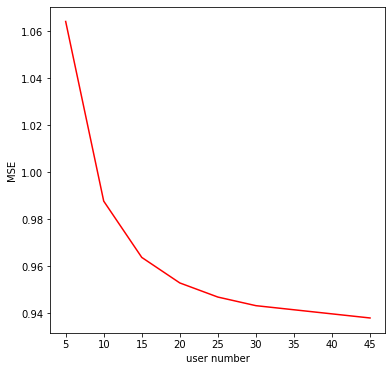

In [130]:
myFigPlot(k_num_list,loss_list_user,labelX='user number',labelY='MSE',lengendName='MSE',col="red")
print(loss_list_user)

[0.9142122727754011, 0.8706608772730511, 0.8647373118187118, 0.8663152707940327, 0.8702841711232967, 0.8751560449462946, 0.889787083246379]


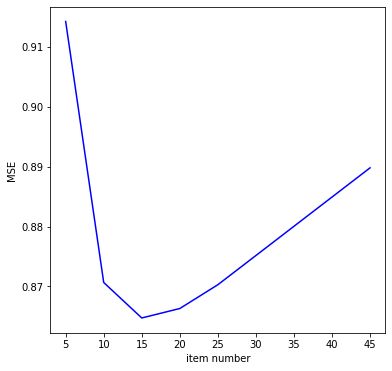

In [97]:
myFigPlot(k_num_list,loss_list_item,labelX='item number',labelY='MSE',lengendName='MSE',col="blue")
print(loss_list_item)